In [42]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

from tensorflow import keras

import utils

plt.rcParams['figure.figsize'] = (25, 8)
plt.rcParams["figure.autolayout"] = True

In [43]:
df_genre = pd.read_csv("./csv-file/all_genre.csv")
df_genre.head()

,id,preview_url,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,analysis_url,duration_ms
0,3dPQuX8Gs42Y7b454ybpMR,https://p.scdn.co/mp3-preview/eca519f0a85862d9...,blues,0.743,0.446,4,-7.807,0,0.0683,0.0039,0.118000,0.3370,0.278,123.596,https://api.spotify.com/v1/audio-analysis/3dPQ...,232107
1,2tznHmp70DxMyr2XhWLOW0,https://p.scdn.co/mp3-preview/a7a72315d777f4ed...,blues,0.636,0.676,2,-3.442,1,0.0263,0.0807,0.000000,0.0831,0.273,113.980,https://api.spotify.com/v1/audio-analysis/2tzn...,208760
2,3Pzh926pXggbMe2ZpXyMV7,https://p.scdn.co/mp3-preview/ada37d5b27a8c23c...,blues,0.636,0.849,0,-7.075,1,0.1060,0.0438,0.000000,0.3720,0.917,156.036,https://api.spotify.com/v1/audio-analysis/3Pzh...,175493
3,4sebUbjqbcgDSwG6PbSGI0,https://p.scdn.co/mp3-preview/a6287f8d65c0ba8b...,blues,0.440,0.778,1,-1.786,0,0.0327,0.0265,0.000001,0.1510,0.304,148.038,https://api.spotify.com/v1/audio-analysis/4seb...,229347
4,5EWPGh7jbTNO2wakv8LjUI,https://p.scdn.co/mp3-preview/5a3cad129336193d...,blues,0.249,0.834,0,-8.210,1,0.0577,0.0738,0.000095,0.0924,0.338,118.223,https://api.spotify.com/v1/audio-analysis/5EWP...,547107


In [44]:
parent_dir = "./music_data/"
list_file_path = []

for genre in df_genre['genre'].unique():
    genre_dir = os.path.join(parent_dir, genre)
    audio_files = os.listdir(genre_dir)
    file_paths = [os.path.join(genre_dir, file) for file in audio_files if file.endswith(".wav")]
    list_file_path.extend(file_paths)
    
df_genre['file_path'] = list_file_path

In [45]:
filename =  df_genre.iloc[0]['file_path']

x, sr = librosa.load(filename, sr=None, mono=True,offset=0.0, duration=5.0)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))
x.shape

Duration: 5.00s, 220500 samples


(220500,)

### แสดงภาพของเสียงในรูป wave radio 
    แสดงค่า aptitude ของเสียงในหนวยเวลา

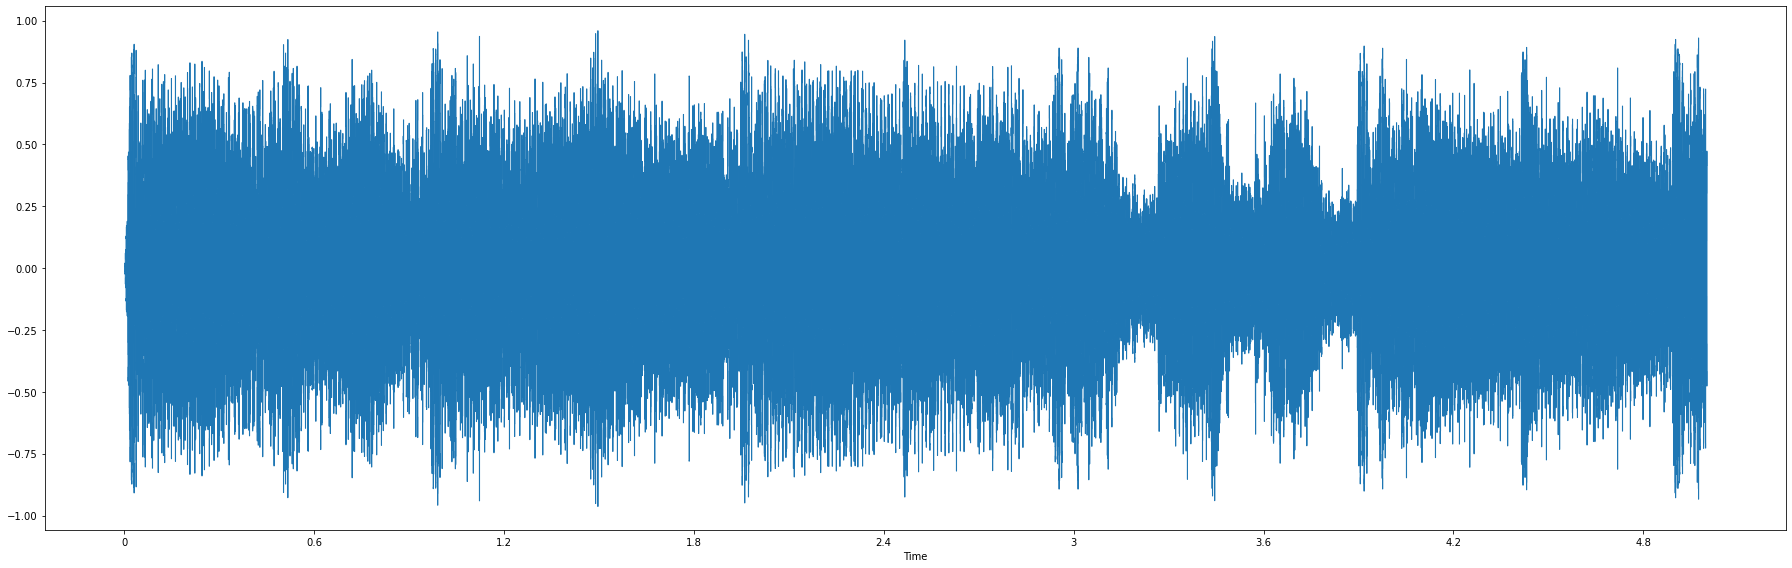

In [46]:
librosa.display.waveshow(x,sr=sr);

### แสดงภาพของเสียงในรูป chroma feature 
    เป็นค่าที่บอกว่าช่วงเวลาหนึ่ง จะมีเสียง melody (C D E F G A B) แบบใด 
    

(12, 431)

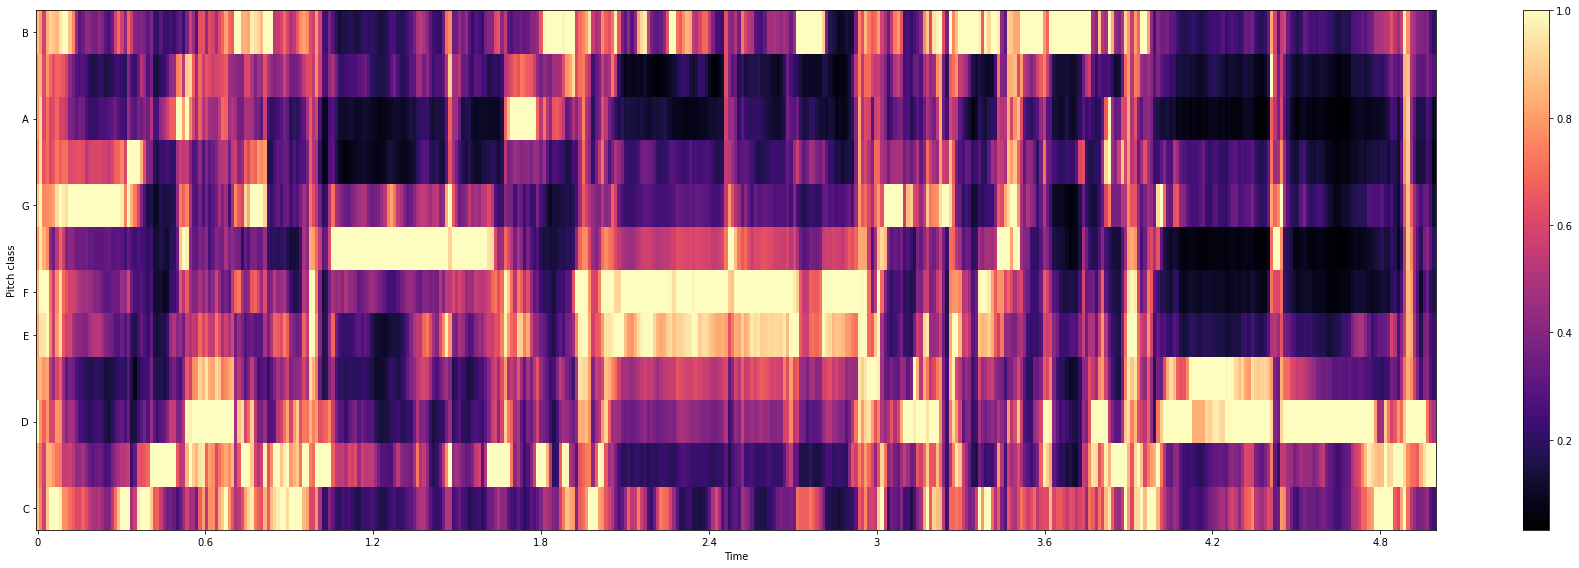

In [47]:
chroma = librosa.feature.chroma_stft(y=x,sr=sr)

fig, ax = plt.subplots()
img = librosa.display.specshow(chroma,sr=sr, y_axis='chroma', x_axis='time', ax=ax)
fig.colorbar(img)
chroma.shape

### แสดงภาพของเสียงในรูป MFCC (Mel frequency cepstrum coefficient)
    การปรับค่าของสเปกตรัมให้อยู่บนสเกลที่เหมาะสมสำหรับการรับฟังของมนุษย์

(20, 431)

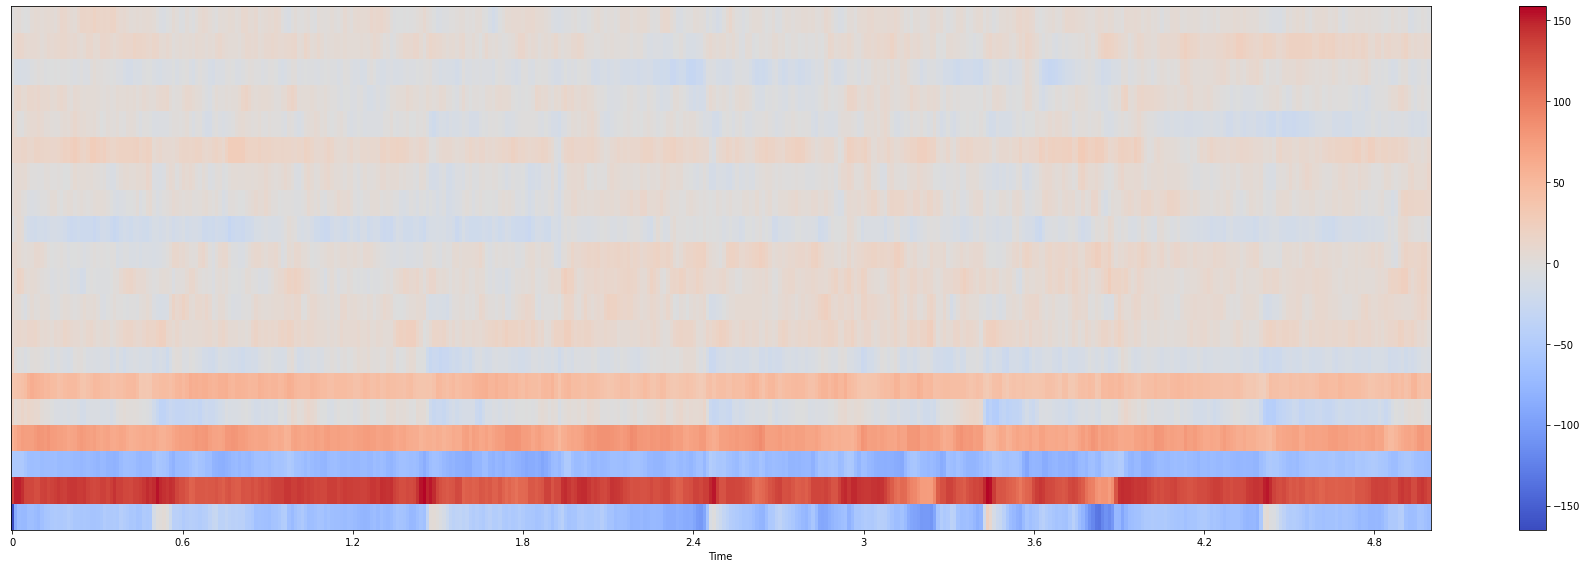

In [48]:
mfccs = librosa.feature.mfcc(y=x, sr=sr)

fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs,sr=sr, x_axis='time', ax=ax)
fig.colorbar(img)
mfccs.shape

# group genre
    เนื่องจาก genre ใน spotify มีจำนวนมากจึงทำให้มีการจัดการที่ลำบากผู้จัดทำจึงได้ทำการสร้าง main genre เพื่อรวมหวมดหมู่ย่อยเข้าด้วยกัน
    
หาข้อมูลสำหรับการรวมกลุ่มเพลงโดยอ้างอิงจาก 3 แหล่งข้อมูลนี้
- https://www.chosic.com/list-of-music-genres/
- https://www.gemtracks.com/guides/view.php?title=complete-list-of-music-genres&id=298
- https://chat.openai.com/

In [49]:
#อ่านข้อมูลไฟล์ที่แบ่ง group
f = open("group-genre_2.txt","r")
text = f.read()
f.close()

genre_group = {}
class_name = []
group_genre = {main_genre : [genre.strip() for genre in sub_genre.split(",")] for main_genre,sub_genre in [i.split(":") for i in text.split("\n")]}

for main_genre,sub_genre in [i.split(":") for i in text.split("\n")]:
    sub_genre = [genre.strip() for genre in sub_genre.split(",")]
    main_genre = main_genre.lower()
    for genre in sub_genre:
        genre_group[genre] = main_genre
        if main_genre not in class_name:
            class_name.append(main_genre)
            
map_class = {main_genre : num for num,main_genre in zip(range(len(class_name)),class_name)}
df_genre['main_genre'] = [map_class.get(genre_group.get(genre)) for genre in df_genre.genre]
df_genre.loc[df_genre.main_genre == len(map_class) - 1].head()

,id,preview_url,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,analysis_url,duration_ms,file_path,main_genre


In [50]:
df_data = df_genre.drop(df_genre.loc[df_genre.main_genre == len(map_class) - 1].index)

ลบหมดหมู่ที่ไม่สามารถใช้งานได้ เนื่องจากเหตุผลต่าง ๆ โดยจัดไว้ใน class not_use เช่น 
- มีหลากหลายหมวดในหมวดเดียวกัน : anime
- เป็นนามธรรมเกินไป : party

โดยได้ลบออกไป 24 หมวด เหลือ 89 หมวด แบ่งได้เป็น 19 class

In [52]:
len(df_genre.genre.unique()) - len(df_data.genre.unique()), len(df_data.genre.unique())

(0, 5)

In [54]:
class_name.remove("not_use")
map_class.pop('not_use')
class_len = len(class_name)

In [55]:
class_len

18

เช็คว่า main genre แต่ละอันประกอบด้วย minor genre เท่าไหร่

In [56]:
n_genre_in_main_genre = df_data.groupby('main_genre')['genre'].nunique()
set(n_genre_in_main_genre)

{1}

ทำการหา ครน. เพื่อทำการ balancing data

In [ ]:
# ครน.
max_n_samples = 720

balanced_data = pd.DataFrame(columns=df_data.columns)

for main_genre in df_data['main_genre'].unique():
    n_genre = n_genre_in_main_genre[main_genre]
    n_sample = max_n_samples // n_genre
    for genre in df_data[df_data["main_genre"] == main_genre]["genre"].unique():
        genre_data = df_data[(df_data["main_genre"] == main_genre) & (df_data["genre"] == genre)]
        sampled_data = genre_data.sample(n=n_sample, random_state=1234)
        
        balanced_data = pd.concat([balanced_data, sampled_data])
    print(balanced_data[balanced_data["main_genre"] == main_genre].groupby('genre').size())
    print("sum genre : {}".format(len(balanced_data[balanced_data["main_genre"] == main_genre])))
    print("="*24)
    
balanced_data = balanced_data.sample(frac=1, random_state=1234)

เนื่องจากข้อมูลมีจำนวนมากจึงทำการเก็บข้อมูลให้อยู่ในรูปของ .npy โดยมีทั้งหมด 4 ไฟล์
- balanced_data.csv csv ที่เก็บข้อมูลหลังจากการทำ balance
- y.npy เก็บผลเฉลย
- chroma.npy เก็บข้อมูลเสียงหลังจากผ่านกระบวนการ chroma
- mfccs.npy เก็บข้อมูลเสียงหลังจากผ่านกระบวนการ mfcc

In [ ]:
from preprocess_audios_mfcc import preprocess_audios_mfcc
from preprocess_audios_chroma import preprocess_audios_chroma
from multiprocessing import cpu_count

n_fft = 4096
hop_length = int(n_fft / 2)
n_mfcc = 48
n_chroma = 48

sr=22050
max_length = 0

offset = 10.0
duration = 20.0

cpus = cpu_count()

#กรณีอยากใช้ข้อมูลเดิม
# balanced_data = pd.read_csv('data_preprocess/balanced_data.csv')


data_dir = "data_preprocess/"

In [ ]:
y = np.array(balanced_data['main_genre'].values)

np.save(data_dir+"y.npy",y)

In [ ]:
mfccs = preprocess_audios_mfcc(balanced_data['file_path'].values,cpus-1,sr=sr,offset=offset,duration=duration,
                               n_mfcc=n_mfcc,n_fft=n_fft,
                               hop_length=hop_length,max_length=max_length)

mfcc_array = np.array(mfccs)
np.save(data_dir+'mfccs.npy', mfcc_array)

In [ ]:
chroma = preprocess_audios_chroma(balanced_data['file_path'].values,cpus-1,sr=sr,offset=offset,duration=duration,
                                  n_fft = n_fft,n_chroma=n_chroma,hop_length = hop_length,
                                  max_length=max_length)

chroma_array = np.asarray(chroma)
np.save(data_dir+'chroma.npy',chroma_array)

In [ ]:
balanced_data['file_path'] = [path.rsplit('\\')[-1] for path in balanced_data['file_path']]
balanced_data.rename(columns={"file_path": "file_name"}).head()
balanced_data.to_csv(data_dir + 'balanced_data.csv',index=False)